**Анализ данных о покупках [Dzaurov Ibragim - IU5]** 

Нужно выполнить предварительную обработку данных, сделать разведочный анализ данных EDA, затем проверить гипотезу о данных, выполнить кластеризацию по товарам, определить важные признаки, построить рекомендательную систему. Метод для составления рекомендаций выбрать самостоятельно.

[Файл с датасетом - dataset.csv] - информация о покупках клиентов:

- [x] _**Дата**_ - [время покупки]

- [x] _**Транзакция**_ - [уникальный номер покупки]

- [x] _**Клиент**_ - [уникальный номер клиента]

- [x] _**Товар**_ - [уникальный номер товара]

- [x] _**Количество**_ - [количество купленных товаров]

- [x] _**Сумма**_ - [цена покупки этого товара]

### 1. Импорт библиотек

In [6]:
# Импортирую библиотеки, необходимые для дальнейшей работы

import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import numpy as np


# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 6, 4
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

In [7]:
# Загружаю файл с данными для получения общей информации о них
data = pd.read_csv('D:\igmsecure/dataset.csv', sep=';')
data.shape

(48303, 6)

In [8]:
data.head() #Вывожу первые строки методом head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0


In [9]:
print('\033[1m' + 'Информация об объеме выборке, типах данных признаков' + '\033[0m')
data.info()

# С помощью методом .info() исследуем соответствие установленных типов признаков их смысловому содержанию
# Метод info() дал нам информацию, из которой ясно, что в таблице 48303 строчки, 6 столбцов

Информация об объеме выборке, типах данных признаков
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Дата        48303 non-null  object 
 1   Транзакция  48303 non-null  int64  
 2   Клиент      48303 non-null  int64  
 3   Товар       48273 non-null  float64
 4   Количество  48303 non-null  float64
 5   Сумма       48303 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.2+ MB


In [11]:
print('\033[1m' + 'Описательные статистики' + '\033[0m')
data.select_dtypes(include = 'number')
# вызываем метод .select_dtypes() и передайте ‘number’ в качестве аргумента для параметра include.
# Мы получаем только те столбцы, которые являются числовыми.

Описательные статистики


,Транзакция,Клиент,Товар,Количество,Сумма
0,954,1,2874.0,1.0,8150.0
1,13796,1,3586.0,1.0,3930.0
2,14431,1,4942.0,1.0,2860.0
3,951,2,2812.0,1.0,4895.0
4,3352,2,5025.0,1.0,840.0
...,...,...,...,...,...
48298,25398,11049,1211.0,1.0,20500.0
48299,25399,11049,3034.0,1.0,21950.0
48300,25412,11050,443.0,1.0,1490.0
48301,25412,11050,2789.0,1.0,9450.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [12]:
# Удаляю дубликаты и проверяю на пустоту, преобразовав их в тип - целых чисел.
for_prediction = data[data['Товар'].isnull()]
data = data[-data['Товар'].isnull()] # Обнаружение пропущенных значений для объекта
data.shape

(48273, 6)

In [13]:
data['Дата'] = pd.to_datetime(data['Дата'])
data['Количество'] = data['Количество'].astype(int)

In [14]:
print(data.shape)
print(data.isnull().sum()) # посмотрим, сколько пропущенных значений в каждой колонке.

(48273, 6)
Дата          0
Транзакция    0
Клиент        0
Товар         0
Количество    0
Сумма         0
dtype: int64


### Поиск дубликатов

In [15]:
data.duplicated() # Удалим дублирующиеся записи

0        False
1        False
2        False
3        False
4        False
         ...  
48298    False
48299    False
48300    False
48301    False
48302    False
Length: 48273, dtype: bool

In [16]:
print('\033[1m' + 'Количество пропущенных значений -- {}'.format(data.isna().sum().sum()) + '\033[0m')

Количество пропущенных значений -- 0


In [17]:
print('\033[1m' + 'Количество дубликатов -- {}'.format(data.duplicated().sum()) + '\033[0m')

Количество дубликатов -- 1127


In [18]:
data.shape[0]

48273

In [19]:
data = data.drop_duplicates(subset = None, keep = 'first', inplace = False)#удаляем повторяющиеся строки

In [20]:
data.columns

Index(['Дата', 'Транзакция', 'Клиент', 'Товар', 'Количество', 'Сумма'], dtype='object')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Дата        47146 non-null  datetime64[ns]
 1   Транзакция  47146 non-null  int64         
 2   Клиент      47146 non-null  int64         
 3   Товар       47146 non-null  float64       
 4   Количество  47146 non-null  int32         
 5   Сумма       47146 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2)
memory usage: 2.3 MB


###  Описательные статистики 

In [22]:
data.describe()

,Транзакция,Клиент,Товар,Количество,Сумма
count,47146.000000,47146.000000,47146.000000,47146.0,47146.000000
mean,13170.802974,4545.535867,3126.636745,1.0,10455.257645
std,7668.957751,3031.557668,1655.168978,0.0,12701.269894
min,1.000000,1.000000,1.000000,1.0,504.000000
25%,6373.250000,2000.000000,1822.000000,1.0,3810.000000
50%,13290.500000,3922.000000,3146.000000,1.0,6910.000000
75%,19749.000000,6903.000000,4803.000000,1.0,12750.000000
max,26512.000000,11050.000000,5523.000000,1.0,511500.000000


In [23]:
print('\033[1m'+ 'Уникальные значения'+'\033[0m'+'\n')
for i in data.columns.to_list():
    print('\033[1m'+ 'Признак {} имеет {} следующих уникальных значений:'.format(i, len(data[i].unique()))+'\033[0m')
    print(data[i].unique())
    print('\033[1m' + '---------------------------------------------------------------------------------'+ '\033[0m')  
#Функция unique() находит уникальные элементы массива и возвращает их в отсортированном массиве.

Уникальные значения

Признак Дата имеет 24775 следующих уникальных значений:
['2020-03-05T21:43:00.000000000' '2020-11-20T20:46:00.000000000'
 '2020-08-12T16:28:00.000000000' ... '2021-06-07T15:00:00.000000000'
 '2021-06-07T15:13:00.000000000' '2021-06-07T15:02:00.000000000']
---------------------------------------------------------------------------------
Признак Транзакция имеет 26381 следующих уникальных значений:
[  954 13796 14431 ... 25398 25399 25412]
---------------------------------------------------------------------------------
Признак Клиент имеет 10989 следующих уникальных значений:
[    1     2     3 ... 11048 11049 11050]
---------------------------------------------------------------------------------
Признак Товар имеет 5293 следующих уникальных значений:
[2874. 3586. 4942. ... 3516. 4151. 2334.]
---------------------------------------------------------------------------------
Признак Количество имеет 1 следующих уникальных значений:
[1]
-------------------------------

### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

In [24]:
#Применяю метод.describe () для получения сводки числовых значений в нашей таблице, вычисления min/max значений.
data[['Количество','Сумма']].describe()

,Количество,Сумма
count,47146.0,47146.000000
mean,1.0,10455.257645
std,0.0,12701.269894
min,1.0,504.000000
25%,1.0,3810.000000
50%,1.0,6910.000000
75%,1.0,12750.000000
max,1.0,511500.000000


In [25]:
print('Минимальная дата -- {}'.format(data['Дата'].min()))
print('Максимальная дата -- {}'.format(data['Дата'].max()))
print('Временной период -- {}'.format(data['Дата'].max()-data['Дата'].min()))

Минимальная дата -- 2020-01-05 11:00:00
Максимальная дата -- 2021-12-07 22:28:00
Временной период -- 702 days 11:28:00


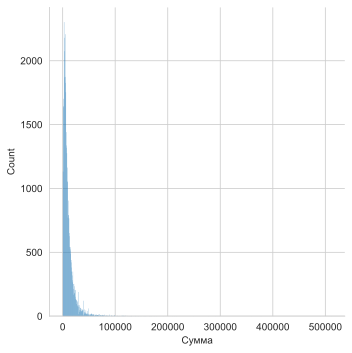

In [26]:
#Для визуализации данных использую тип графика displot, построив диаграмму 
ax = sns.displot(data['Сумма'].astype(int))

In [27]:
# Далее, строю сводную таблицу и группирую ее по дате и сумме,избавляясь от индекса
data['Дата2'] = data['Дата'].dt.date
data2 = data[['Сумма','Дата2']].groupby('Дата2').sum().sort_values('Дата2', ascending = True).reset_index()
data2
# получаем в результате преобразования новую дату, отрезанную от времени

,Дата2,Сумма
0,2020-01-05,2999052.96
1,2020-01-06,184500.00
2,2020-01-07,430400.00
3,2020-01-08,208770.00
4,2020-01-09,926915.00
...,...,...
461,2021-12-03,234379.50
462,2021-12-04,517908.50
463,2021-12-05,1578498.87
464,2021-12-06,2131892.95


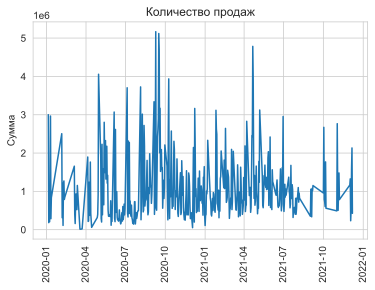

In [28]:
# Создаю график линейной зависимости между суммой и датой (по оси Х установлено направление текста под углом в 90 градусов)
# где в качестве переменной Х будет Дата, а в качестве У - Сумма.
plt.plot(data2['Дата2'], data2['Сумма'])
plt.title('Количество продаж')
plt.ylabel('Сумма')
plt.xticks(rotation = 90)
plt.show()

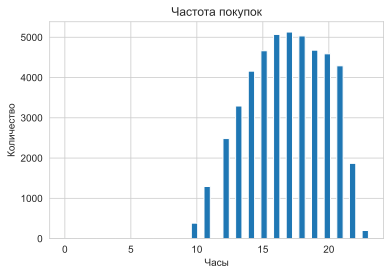

In [29]:
# Гистограмма по часам с использованием функции форматирования времени(выделения часов)
plt.hist(data['Дата'].dt.hour.values, bins=48)
plt.xlabel('Часы')
plt.ylabel('Количество')
plt.title('Частота покупок');

In [30]:
# Показываю самые прибыльные позиции за все время
profitability = data[['Товар','Количество','Сумма']].groupby('Товар').sum().sort_values('Сумма', ascending = False).reset_index()
profitability.head()

,Товар,Количество,Сумма
0,3060.0,156,7114347.53
1,4757.0,281,6684277.87
2,4944.0,725,5092324.27
3,3487.0,435,4566229.85
4,2430.0,94,3805189.37


In [32]:
data_sum['Процент_продаж'] = data_sum['Сумма'] / data_sum['Сумма'].sum() * 100
data_sum['Процент_количество'] = data_sum['Количество'] / data_sum['Количество'].sum() * 100
data_sum = data_sum.sort_values('Процент_продаж', ascending = False)
data_sum['Сумма_продаж'] = data_sum['Процент_продаж'].cumsum()
data_sum = data_sum.sort_values('Процент_количество', ascending = False)
data_sum['Сумма_количество'] = data_sum['Процент_количество'].cumsum()
data_sum.head()
# вычисляем процент, который попадает конткретно на количество проданных товаров от общего количества и вычисляем  кумулятивную (накапливаемую) сумму


,Товар,Количество,Сумма,Процент_продаж,Процент_количество,Сумма_продаж,Сумма_количество
4744,4944.0,725,5092324.27,1.033086,1.537776,3.832430,1.537776
4714,4911.0,580,1823693.31,0.369975,1.230221,13.936921,2.767997
3366,3487.0,435,4566229.85,0.926357,0.922666,4.758786,3.690663
417,434.0,430,1747247.86,0.354466,0.912060,14.291388,4.602723
2542,2635.0,425,1211674.74,0.245814,0.901455,24.168217,5.504179


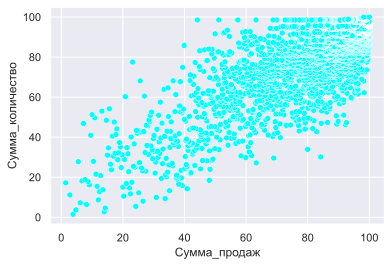

In [33]:
sns.set()
ax = sns.scatterplot(x = 'Сумма_продаж', y = 'Сумма_количество', data = data_sum, color = 'cyan')
plt.show()

**Корреляция**

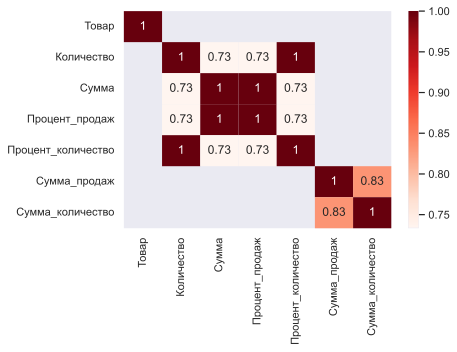

In [34]:

corr = data_sum.corr()
corr_greater_than_50 = corr[corr>=.5]
corr_greater_than_50
sns.heatmap(corr_greater_than_50, cmap="Reds", annot = True);

# Строим тепловую карту. sns.heatmap наглядно показывает, как изменяется интересующее нас значение 
#в зависимости от значений двух других переменных. Здесь малоценные изображения отображаются в цвете низкой интенсивности,
#а высокоценные - в цветовом формате высокой интенсивности.

### Вывод

В рамках данной лабораторной выполнялись работы по анализу и обработке данных.
Данные представляют собой записи о совершенных покупках клиента за период c 2020-01-05 по 2021-12-07.
Задача данной работы заключается в предварительной обработке данных, разведочном анализе данных EDA, определении важных признаков, построении рекомендательной
системы.

В качестве инструмента выполнения проекта использовался язык программирования python, библиотеки pandas, numpy, scipy, math,  matplotlib и seaborn. 

Решение поставленной задачи проекта проводилось в несколько этапов.
На первом этапе реализована загрузка данных , содержащихся в csv-файле, а также их первичное исследование методами (head(), 
 info() и describe()).

В результате было установлено, что 1) данные загружены корректно; 2)в данных отсутствовали пропущенные значения;
3 дублирующихся записей нет.

На следующем этапе проводилась первичная обработка данных в соответствии с результатами предыдущего этапа. 
В частности, выялялись уникальные значения, определен временной интервал, за который представлены данные и найдены
минимальная и максимальная даты.

Для визуализации данных был построен график с помощью функции displot()
Из которого можно наблюдать гистограмму суммы совершаемых покупок клиентами.(до 100000 у.е)

Затем, в рамках проведения описательной статистики, построил вводную таблицу и группирую ее по дате и сумме,
избавляясь от индекса,получив в результате преобразования новую дату, отрезанную от времени.
 
После чего, создан график линейной зависимости между суммой и датой (по оси Х установлено направление текста под углом в 
                                                                      90 градусов)
где в качестве переменной Х - Дата, а в качестве У - Сумма.

Из построенного графика видим, что исследуемые признаки имеют корректные значения.
Была построена гистограмма по часам с использованием функции форматирования времени(выделения часов) за 48 часов.
Из чего мы видим, в какие часы было совершено большее количество транзакций. 
С помощью profitability.head() выводим самые прибыльные позиции за все время и вычисляем процент, который попадает 
конткретно на количество проданных товаров от общего количества и вычисляем  накапливаемую сумму
вычисляем процент, который попадает конткретно на количество проданных товаров от общего количества и вычисляем  кумулятивную 
сумму.

Построение точечной диаграммы seaborn с использованием sns.scatterplot() где x, y - сумма продаж и количество соответственно

Строим тепловую карту. sns.heatmap наглядно показывает, как изменяется интересующее нас значение в зависимости от значений 
двух других переменных.
Здесь малоценные изображения отображаются в цвете низкой интенсивности,
а высокоценные - в цветовом формате высокой интенсивности.
